<a href="https://colab.research.google.com/github/ajuhz/Artificial-Intelligence/blob/master/Transfer_Learning_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: This is a simplified and more explainable version from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [2]:
#Data Augmentation and normalization for training

# Data augmentation and normalization for training
# Just normalization for validation
#class torchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)
#transforms.RandomResizedCrop(224) --> A crop of random size (default: of 0.08 to 1.0) of the original size and a 
#random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
#This crop is finally resized to given size (224 in this case). 
#transforms.CenterCrop(224)--> Crops the image at the center. 224 is the Desired output size of the crop.
#class torchvision.transforms.Normalize(mean, std)
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, 
#this transform will normalize each channel of the input torch.Tensor i.e. 
#input[channel] = (input[channel] - mean[channel]) / std[channel]
#Parameters:     mean (sequence) – Sequence of means for each channel.
#                std (sequence) – Sequence of standard deviations for each channel.
data_transforms={'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                 'val' : transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),}



In [3]:
!pwd

/content


In [4]:
%cd /content/drive/My Drive/Python

/content/drive/My Drive/Python


In [5]:
data_dir = 'hymenoptera_data'

In [6]:
#Create a dictionary that contains the information of the images in both the training and validation set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
#Create a dictionary that contians the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True) for x in ['train', 'val']}
#Create a dictionary that contains the size of each dataset (training and validation)


In [7]:
dataset_sizes={x: len(image_datasets[x]) for x in ['train','val']}
print('Dataset sizes are {}'.format(dataset_sizes))
print('Dataloader batch sizes are Train : {} Test : {}'.format(len(dataloaders['train']),len(dataloaders['val'])))


Dataset sizes are {'train': 244, 'val': 152}
Dataloader batch sizes are Train : 61 Test : 38


In [8]:
next(iter(dataloaders['train']))

[tensor([[[[-0.6623, -0.7137, -0.7137,  ..., -0.8335, -0.8678, -0.9192],
           [-0.6794, -0.7308, -0.6965,  ..., -0.8164, -0.8164, -0.8678],
           [-0.5938, -0.6281, -0.6623,  ..., -0.7993, -0.7993, -0.8507],
           ...,
           [ 1.0673,  1.1187,  1.1358,  ...,  0.8104,  0.7762,  0.6906],
           [ 1.1358,  1.2043,  1.2899,  ...,  0.8961,  0.8618,  0.7591],
           [ 1.0159,  1.1358,  1.2899,  ...,  0.8447,  0.8276,  0.7762]],
 
          [[-0.4251, -0.4426, -0.4426,  ..., -0.6352, -0.6352, -0.6527],
           [-0.3725, -0.4251, -0.4601,  ..., -0.6877, -0.6877, -0.6702],
           [-0.4601, -0.4426, -0.4426,  ..., -0.6702, -0.6527, -0.6352],
           ...,
           [ 0.9580,  0.9580,  0.9580,  ...,  0.8354,  0.8529,  0.8880],
           [ 0.9930,  1.0455,  1.0980,  ...,  0.8354,  0.8354,  0.7654],
           [ 0.9055,  1.0105,  1.1155,  ...,  0.7479,  0.8179,  0.8529]],
 
          [[-1.3687, -1.3861, -1.3861,  ..., -1.3861, -1.4036, -1.4210],
           [-

In [9]:
#load trained ResNet
model_conv=torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [10]:
#freezing all layers of the model
for params in model_conv.parameters():
  params.requires_grad=False

In [11]:
print(model_conv.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [12]:
#Get the number of inputs of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
#Reconstruct the last layer (output layer) to have only two classes 
model_conv.fc = nn.Linear(num_ftrs, 2)

In [13]:
model_conv.state_dict

<bound method Module.state_dict of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [14]:
torch.cuda.is_available()

True

In [15]:
model_conv=model_conv.cuda()

In [16]:
#Understand what's happening
iteration = 0
correct = 0
for inputs,labels in dataloaders['train']:
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([1, 0, 1, 1], device='cuda:0')
Output Tensor: tensor([[ 0.0577, -0.2725],
        [-0.1278, -0.2910],
        [ 0.3878, -0.0018],
        [ 0.6206,  0.2066]], device='cuda:0', grad_fn=<AddmmBackward>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 0], device='cuda:0')
Predicted Shape torch.Size([4])
Correct Predictions: tensor(1, device='cuda:0')


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#Try experimenting with: optim.Adam(model_conv.fc.parameters(), lr=0.001)
#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
num_epochs = 25
for epoch in range (num_epochs):
    exp_lr_scheduler.step()
    #Reset the correct to 0 after passing through all the dataset
    correct = 0
    for images,labels in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        optimizer.zero_grad()
        outputs = model_conv(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == labels).sum()
        
    train_acc = 100 * correct // dataset_sizes['train']    
    print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {}%'
            .format(epoch+1, num_epochs, loss.item(), train_acc))

Epoch [1/25], Loss: 2.1606, Train Accuracy: 79%
Epoch [2/25], Loss: 0.9221, Train Accuracy: 73%
Epoch [3/25], Loss: 0.7206, Train Accuracy: 80%
Epoch [4/25], Loss: 0.0284, Train Accuracy: 83%
Epoch [5/25], Loss: 0.0457, Train Accuracy: 73%
Epoch [6/25], Loss: 0.3354, Train Accuracy: 82%
Epoch [7/25], Loss: 0.5432, Train Accuracy: 86%
Epoch [8/25], Loss: 0.0196, Train Accuracy: 78%
Epoch [9/25], Loss: 0.2314, Train Accuracy: 84%
Epoch [10/25], Loss: 0.3310, Train Accuracy: 80%
Epoch [11/25], Loss: 0.0386, Train Accuracy: 79%
Epoch [12/25], Loss: 0.1028, Train Accuracy: 85%
Epoch [13/25], Loss: 0.3266, Train Accuracy: 86%
Epoch [14/25], Loss: 0.0554, Train Accuracy: 87%
Epoch [15/25], Loss: 0.3022, Train Accuracy: 85%
Epoch [16/25], Loss: 0.2518, Train Accuracy: 83%
Epoch [17/25], Loss: 0.0587, Train Accuracy: 86%
Epoch [18/25], Loss: 0.0390, Train Accuracy: 83%
Epoch [19/25], Loss: 0.0555, Train Accuracy: 80%
Epoch [20/25], Loss: 0.0199, Train Accuracy: 84%
Epoch [21/25], Loss: 0.0421, 

In [20]:
# Test the model
model_conv.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 95.395 %


In [23]:
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


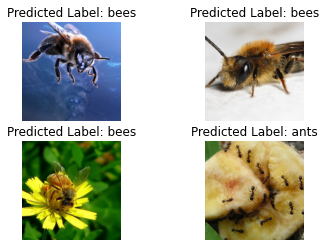

In [24]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)

In [31]:
from PIL import Image
import numpy as np

In [55]:
test_image=Image.open('/content/drive/My Drive/Python/test ant image.jpg')
test_image=test_image.resize([224,224])


In [56]:

test_image=data_transforms['val'](test_image)
test_image=test_image.view(-1,3,224,224)
print(test_image)

tensor([[[[ 0.7077,  0.7248,  0.7077,  ..., -0.7479, -0.7650, -0.7822],
          [ 0.7248,  0.7248,  0.7248,  ..., -0.6965, -0.7137, -0.7479],
          [ 0.7419,  0.7248,  0.7248,  ..., -0.6623, -0.6623, -0.7137],
          ...,
          [ 0.9817,  0.9303,  0.8961,  ...,  0.2282,  0.6221,  0.8789],
          [ 1.0159,  0.9132,  0.8447,  ...,  0.9132,  0.7077,  0.7762],
          [ 1.0502,  0.9474,  0.8447,  ...,  0.3652,  0.0912,  0.4679]],

         [[ 0.6954,  0.6779,  0.6604,  ..., -0.8803, -0.8978, -0.9153],
          [ 0.6779,  0.6779,  0.6779,  ..., -0.8452, -0.8627, -0.8803],
          [ 0.6954,  0.6779,  0.6779,  ..., -0.8277, -0.8102, -0.8452],
          ...,
          [ 0.8704,  0.7829,  0.6779,  ...,  0.1527,  0.4853,  0.7129],
          [ 0.8529,  0.7479,  0.6254,  ...,  0.8529,  0.5203,  0.6254],
          [ 0.8529,  0.7479,  0.6604,  ...,  0.2402, -0.0399,  0.4153]],

         [[ 0.8274,  0.8274,  0.8099,  ..., -0.8807, -0.8981, -0.9156],
          [ 0.8274,  0.7925,  

In [57]:
test_image.shape

torch.Size([1, 3, 224, 224])

In [60]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
with torch.no_grad():
  images = Variable(test_image)
  if torch.cuda.is_available():
    images = images.cuda()
    outputs = model_conv(images)                            #The output is of shape (4,2)
    _, preds = torch.max(outputs, 1)
    print(class_names[preds])                        #The pred is of shape (4) --> [ 0,  0,  0,  1]

ants


<Figure size 432x288 with 0 Axes>